### Prep:

* Resample all inputs see 1-Resample Input Data.ipynb
* Rasterize fires and organize by time period see 2-RasterizeFirePolygons_OrganizeData.ipynb

### Data Structure:
Data should be structured as follows:

* Independent Vars 2012-2016
    * aet
        * aet-201201.tif
        * ...
        * aet-201612.tif
    * cwd
        * cwd-201201.tif
        * ...
        * cwd-201612.tif
    * ppt
        * ppt-201201.tif
        * ...
        * ppt-201612.tif
    * ...
* Independent Vars 2017-2021
    * ...
* Dependent Var 2012-2016
    * Fire-2012-2016
* Dependent Var 2017-2021
    * Fire-2017-2021

In [1]:
import tsraster.prep as tr
import tsraster.random as random
import tsraster.calculate as ca
import numpy as np

import tsraster.model  as md
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
from tsraster.prep import set_df_mindex
import copy

In [ ]:
### 

In [2]:
########################### 

In [3]:
#construct poisson disk mask
'''
Create raster of cells to be selected (populated as ones) in a raster of background value zero

:param raster_mask: name of raster mask - provides dimensions for subsample, and also masks unusable areas - IS ASSUMED TO BE CONTIGUOUS
:param k: number of attempts to select a point around each reference point before marking it as inactive
:param r: minimum distance (in raster cells) between selected points 
'''


rasterMask = random.Poisson_Subsample(raster_mask = r"../Data\Examples\buffer\StatePoly_buf.tif",
                                      outFile = r"../Data\Examples\diskTest.tif",
                                      k=50, 
                                      r=10)[0]

In [5]:
#combine all data that is invariant over time into single dataFrame

'''Combines set of rasters to single dataFrame based on csv that lists all desired files and column names to use in dataframe for data
 corresponding to each raster
 '''

#param csvPath: path to csv of filepaths (in column "FilePath") and desired label names for values in each raster (in column "DataName")
#param outPath: path to ouput file name and location

invar_Data = tr.multi_image_to_dataframe("C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Actual/Invar_FileList.csv", "C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Actual/invar_out_test.csv")
invar_Data.head()

,Campground,FireStation_Dist,Airfield_Dist,City_Bounds,NPS_Bounds,Lightning,Elev
pixel_id,,,,,,,
0,-1,121,78,-1,-1,0,-15
1,-1,-23,-66,-1,-1,0,-15
2,-1,95,49,-1,-1,0,-15
3,-1,-38,-88,-1,-1,0,-15
4,-1,91,34,-1,-1,0,-15


In [6]:
#conduct climate feature extraction across all years of interest, merge results with invar data annually


'''Extracts summary statistics(features) from multiYear datasets within moving window, across years
    Outputs a series of annual dataFrames as CSV files
'''

#param startYear: year on which to start feature extraction
#param endYear: year on which to end feature extraction
#param featureData_Path: file path to data from which to extract features
#param feature_params: summary statistics(features) to extract from data within each window
#param invar_Data: year-invariate data to join with extracted feature data on an annual scale
#param out_Path: file path to location at which extracted features should be output as a csv
#param window_length: length of window within which to extract features
#param window_offset: number of years by which features pertaining to each year are offset from that year
#param mask:  mask to apply to data prior to feature extraction

ca.multiYear_Window_Extraction(1981, 1982, "C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Actual/Climate/BCM HIST Final 1000m_1950_2016/",
                    feature_params = {"mean": None,"maximum": None}, 
                    invar_Data = invar_Data,
                    out_Path = 'C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/',
                        mask = "C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Examples/buffer/StatePoly_buf.tif" ,
                    window_length = 3,
                    window_offset = 0)

df: C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Actual/Climate/BCM HIST Final 1000m_1950_2016/my_df.csv


Feature Extraction: 100%|████████████████████████| 5/5 [01:13<00:00, 15.02s/it]


features:C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/extracted_features1981_3_prev_offset0.csv
tif:C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/extracted_features1981_3_prev_offset0.tiff
df: C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Actual/Climate/BCM HIST Final 1000m_1950_2016/my_df.csv


Feature Extraction: 100%|████████████████████████| 5/5 [01:19<00:00, 16.39s/it]


features:C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/extracted_features1982_3_prev_offset0.csv
tif:C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/extracted_features1982_3_prev_offset0.tiff


In [3]:
'''merge additional annually repeating data into feature data (which is already merged with time-invariant data)
    Produces annual dataFrames consisting of all explanatory variables that may be incorporated into model
'''
    
#param startYear: year on which to start feature extraction
#param endYear: year on which to end feature extraction
#param other_Data_prefixList: list of file path and portion of filename preceding year for additional Data
#param feature_Data_suffixList: portion of feature data file name that follows year for additional data
#param dataNameList: list of intended data names for additional data
#param outPath: filepath for folder in which the output will be placed


tr.annual_Data_Merge(1981, 1982, 
                  "C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/", 
                 ["C:/Users/Python3/Documents/wildfire_FRAP/Data/Actual/SERGOM_Housing/Interpolated/bhc"],
                 ["linreg.tif"],
                 ["Housing_Density"],
                 'C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/')

In [4]:
#converts annual fire raster data into annual CSV files, does some minor reformatting for downstream processing
'''convert annual fire data rasters into annual dataFrames, export as .CSV files
    also does some minor reformatting to prevent problems with downstream processing
'''
    
    #param startYear: year on which to start feature extraction
    #param endYear: year on which to end feature extraction
    #param file_Path: path to target data files (fire data)
    #outPath: filepath for folder in which the output will be placed: 



tr.target_Data_to_csv_multiYear(1981, 1982,
                            "C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Actual/Fires/Rasters/",
                            'C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/')

In [2]:
'''masks annual datasets (combined and fire), and saves the resulting masked data files as CSV files
    Also returns multiYear files (combined and fire) for subsequent processing - adds in 'year' as a data column
'''
    #param startYear: year on which to begin
    #param endYear: year on which to end
    #param DataLists: csv of files to pull, with the year is the index, 
    #       "combined_Data_Filepaths" as the column of combined data filepaths, and
    #       "target_Data_filePaths" as the column of the target data(i.e. fire) filepaths.
    #param maskFile: filepath to data file used for masking
    #outPath: filepath for folder in which the output will be placed


combined_Data, target_Data = tr.multiYear_Mask(1981, 1982, 
                                               'C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/', 
                                               r"../Data\Examples\diskTest.tif", 
                                               "C:/Users/Python3/Documents/wildfire_FRAP_working/wildfire_FRAP/Data/Extracted_Features/Masked/")

C:\Users\Python3\Anaconda3\envs\ts-raster\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
'''Assigns each pixel and year to a randomly assigned group in order to allocate them for testing and training- 
'''


#param combined_Data:  multivariate data for explaining target data - may be filename or csv
#param combined_Data: target data - may be filename or csv
#param varsToGroupBy: variable(s) on which to build groups for testing/training
#param groupVars: variable(s) to name those groups
#param tesGroups: number of randomly assigned groups to provide for each variable



combined_Data2, target_Data2 = random.TestTrain_GroupMaker(combined_Data, target_Data, ["pixel_id", "year"], ["pixel_group", "year_group"], testGroups = [10, 6])
combined_Data2.head()

,pixel_id,Unnamed: 0,Unnamed: 0.1,time,aet__maximum,aet__mean,cwd__maximum,cwd__mean,Campground,FireStation_Dist,Airfield_Dist,City_Bounds,NPS_Bounds,Lightning,Elev,Housing_Density,year,pixel_group,year_group
0,135532,135532,135532,197901_198112,146.348801,52.559612,51.924400,29.699389,-1,122,125,-1,-1,0,-114,1,1981,6,3
1,135544,135544,135544,197901_198112,159.460007,59.854465,34.564999,18.978876,-1,-115,-42,-1,-1,0,44,0,1981,2,3
2,136499,136499,136499,197901_198112,82.879379,25.414602,105.540627,51.545486,-1,-107,-31,-1,-1,0,-75,0,1981,4,3
3,137476,137476,137476,197901_198112,143.273605,53.919800,47.438000,22.393867,-1,-42,110,-1,-1,0,-100,0,1981,1,3
4,137486,137486,137486,197901_198112,118.560799,45.622555,65.917999,33.337620,-1,-105,87,-1,-1,0,17,0,1981,0,3


In [12]:
def elasticNet_2dimTest(combined_Data, target_Data, varsToGroupBy, groupVars, testGroups):

    combined_Data, target_Data = random.TestTrain_GroupMaker(combined_Data, target_Data, 
                                                               varsToGroupBy, 
                                                               groupVars, 
                                                               testGroups)


    #select out test/training data for each iteration by pixels, years, and both 
    #(test against temporally alien, spatially alien,and completely alien conditions)

    #get list of group ids, since in cases where group # <10, may not begin at zero
    pixel_testVals = list(set(combined_Data[groupVars[0]].tolist()))
    year_testVals = list(set(combined_Data[groupVars[1]].tolist()))

    pixels_years_MSEList = []
    pixels_MSEList = []
    years_MSEList = []

    pixels_years_R2List = []
    pixels_R2List = []
    years_R2List = []

    for x in pixel_testVals:



        for y in year_testVals:
            trainData_X = combined_Data[combined_Data[groupVars[0]] != x]
            trainData_X = trainData_X[trainData_X[groupVars[1]] != y]

            trainData_y = target_Data[target_Data[groupVars[0]] != x]
            trainData_y = trainData_y[trainData_y[groupVars[1]] != y]


            testData_X_pixels_years = combined_Data[combined_Data[groupVars[0]] == x]
            testData_X_pixels_years = testData_X_pixels_years[testData_X_pixels_years[groupVars[1]] == y]

            testData_X_pixels = combined_Data[combined_Data[groupVars[0]] == x]
            testData_X_pixels = testData_X_pixels[testData_X_pixels[groupVars[1]] != y]

            testData_X_years = combined_Data[combined_Data[groupVars[0]] != x]
            testData_X_years = testData_X_years[testData_X_years[groupVars[1]] == y]



            testData_y_pixels_years = target_Data[target_Data[groupVars[0]] == x]
            testData_y_pixels_years = testData_y_pixels_years[testData_y_pixels_years[groupVars[1]] == y]

            testData_y_pixels = target_Data[target_Data[groupVars[0]] == x]
            testData_y_pixels = testData_y_pixels[testData_y_pixels[groupVars[1]] != y]

            testData_y_years = target_Data[target_Data[groupVars[0]] != x]
            testData_y_years = testData_y_years[testData_y_years[groupVars[1]] == y]


            pixels_years_iterOutput = md.ElasticNetModel(trainData_X, trainData_y['value'], testData_X_pixels_years, testData_y_pixels_years['value'])
            pixels_iterOutput = md.ElasticNetModel(trainData_X, trainData_y['value'], testData_X_pixels, testData_y_pixels['value'])
            years_iterOutput = md.ElasticNetModel(trainData_X, trainData_y['value'], testData_X_years, testData_y_years['value'])



            pixels_years_MSEList.append(pixels_years_iterOutput[1])
            pixels_MSEList.append(pixels_iterOutput[1])
            years_MSEList.append(years_iterOutput[1])

            pixels_years_R2List.append(pixels_years_iterOutput[2])
            pixels_R2List.append(pixels_iterOutput[2])
            years_R2List.append(years_iterOutput[2])

    print("pixels_Years MSE Overall: ", sum(pixels_years_MSEList)/len(pixels_years_MSEList))
    print("pixels_Years R2 Overall: ", sum(pixels_years_R2List)/len(pixels_years_R2List))
    print("pixels_Years R2 iterations: ", pixels_years_R2List)
    print("\n")
    print("pixels MSE Overall: ", sum(pixels_MSEList)/len(pixels_MSEList))
    print("pixels R2 Overall: ", sum(pixels_R2List)/len(pixels_R2List))
    print(len(pixels_R2List))
    print("pixels R2 iterations: ", pixels_R2List)
    print("\n")
    print("years MSE Overall: ", sum(years_MSEList)/len(years_MSEList))
    print("years R2 Overall: ", sum(years_R2List)/len(years_R2List))
    print(len(years_R2List))
    print("years R2 iterations: ", years_R2List)
    print("\n")

            #select out test/training data for each iteration by years

In [13]:
elasticNet_2dimTest(combined_Data, target_Data, ["pixel_id", "year"], ["pixel_group", "year_group"], testGroups = [10, 6])


pixels_Years MSE Overall:  -0.000972436612029443
pixels_Years R2 Overall:  -205002.34458079853
pixels_Years R2 Overall:  -9318.288390036296
22
pixels_Years R2 iterations:  [-0.4457043592507326, -11.635626510117762, -1720.8789927516218, -1.2806626448829541, -0.48460978904667207, -9.156130726914144, -0.30112045843711943, -11.094565836789549, -0.4321624831091917, -10.515615015696815, -0.39965899996836884, -10.135176522503462, -0.37532918037109786, -10.787805700455525, -6699.372958519421, -143639.5612080204, -0.585867160544008, -10.981014019785922, -2591.5394564362186, -50272.380915663016, 0.0, 0.0]


pixels MSE Overall:  -0.0008353898245174538
pixels R2 Overall:  -8208.142324171187
22
pixels R2 iterations:  [-0.4457043592507326, -11.635626510117762, -0.32578318856147415, -10623.380499376255, -0.48460978904667207, -9.156130726914144, -0.30112045843711943, -11.094565836789549, -0.4321624831091917, -10.515615015696815, -0.39965899996836884, -10.135176522503462, -0.37532918037109786, -10.7878

In [ ]:
###################

In [ ]:
obj = [target_data,extracted_features]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False  )

In [14]:
relevance_test, relevant_features  = ca.checkRelevance2(x=X_train, 
                                                        y=y_train,
                                                        fdr_level=0.01)
print(relevance_test)
relevant_features.head()

                   feature  type       p_value  relevant
feature                                                 
aet__maximum  aet__maximum  real  6.993191e-23      True
aet__mean        aet__mean  real  7.604158e-21      True
cwd__mean        cwd__mean  real  2.424042e-14      True
cwd__maximum  cwd__maximum  real  1.681569e-13      True


,,aet__maximum,aet__mean,cwd__mean,cwd__maximum
pixel_id,time,,,,
613782,199701_199912,147.283600,41.908684,57.450752,131.722397
758707,199501_199712,142.056503,43.035862,69.082191,153.076996
1042362,199701_199912,134.751251,40.237396,68.876823,136.493118
597693,199501_199712,72.180000,25.977777,67.088882,132.429993
666588,199701_199912,101.658997,23.553017,91.105591,202.184998


In [15]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train[relevant_features.columns], y_train)

In [16]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = relevant_features.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances

,importance
aet__mean,0.367164
cwd__maximum,0.321893
aet__maximum,0.195558
cwd__mean,0.115384


In [17]:
#Get target year's data

projectedYear = ca.calculateFeatures_window(path = "C:/Users/Python3/Documents/wildfire_FRAP/Data/Actual/Climate/BCM HIST Final 1000m_1950_2016/", 
                                              parameters = {"mean": None,
                                                            "maximum": None}, 
                                              baseYear = 2003,
                                              length = 3,
                                              offset = 0,
                                              reset_df=True,
                                              raster_mask =  "C:/Users/Python3/Documents/wildfire_FRAP/Data/Examples/buffer/StatePoly_buf.tif" ,
                                              tiff_output=True,
                                              workers = 1,
                                              outPath = 'C:/Users/Python3/Documents/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/')
    



#Predict to Novel Data
all_predict = md.model_predict(model = clf,
                                        new_X = projectedYear[relevant_features.columns])

# returns probability of each class
all_prob =  md.model_predict_prob(model = clf,
                                        new_X = projectedYear[relevant_features.columns])

df: C:/Users/Python3/Documents/wildfire_FRAP/Data/Actual/Climate/BCM HIST Final 1000m_1950_2016/my_df.csv


Feature Extraction: 100%|████████████████████████| 5/5 [01:20<00:00, 16.76s/it]


features:C:/Users/Python3/Documents/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/extracted_features2003_3_prev_offset0.csv
tif:C:/Users/Python3/Documents/wildfire_FRAP/Data/Extracted_Features/Pre_Masked/extracted_features2003_3_prev_offset0.tiff


In [18]:
print(all_predict.head())
all_prob.head()

pixel_id  time         
0         200101_200312    0
1         200101_200312    0
2         200101_200312    0
3         200101_200312    0
4         200101_200312    0
dtype: int8


,,0,1
pixel_id,time,,
0,200101_200312,0.999391,0.000609
1,200101_200312,0.999391,0.000609
2,200101_200312,0.999391,0.000609
3,200101_200312,0.999391,0.000609
4,200101_200312,0.999391,0.000609


C:\Users\Python3\Anaconda3\envs\ts-raster\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


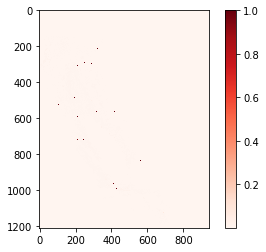

In [27]:
import rasterio
from numpy import reshape
raster_ex = "../Data/Examples/3month/aet-198401.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = reshape(all_prob[1].as_matrix(), (ex_row, ex_cols))
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [28]:
with rasterio.open("../Data/Examples/3month/aet-198401.tif") as exampleRast:
        array = exampleRast.read()
        profile = exampleRast.profile
        profile.update(dtype=rasterio.float32, count=1, compress='lzw',nodata=0)

f2Array = np.float32(f2Array)      
        
with rasterio.open("../Data/Examples/Prob_Out/Prob_Out.tif", 'w', **profile) as prob_iter:
    prob_iter.write(f2Array, 1)

In [ ]:
#################################

In [6]:
raster_mask = r"../Data\Examples\buffer\StatePoly_buf.tif"

# combine in list to make sure they return same number of rows


target_data_mask = tr.mask_df(raster_mask,
                                   original_df=r"../Data/Examples/3month_fire/fire_1984.tif",
                                   reset_index = False)
target_data_mask.head()



FileNotFoundError: File b'../Data/Examples/3month_fire/fire_1984.tif\\my_df.csv' does not exist

In [ ]:
extracted_features.head(3)

In [ ]:
extracted_features.describe()

In [ ]:
# first, get the original dimension/shape of image 
og_rasters = tr.image_to_array_window(path = "C:/Users/Python3/Documents/wildfire_FRAP/Data/Actual/Climate/BCM HIST Final 1000m_1950_2016/", baseYear = 2002, length = 1, offset = 1)
rows, cols, nums = og_rasters.shape


# convert df to matrix array
matrix_features = extracted_features.values
num_of_layers = matrix_features.shape[1]


f2Array = matrix_features.reshape(rows, cols, num_of_layers)
print(f2Array.shape)

plt.subplots(1, 1,figsize=(10,10))
cols = 3

for i in range(0,f2Array.shape[2]):
    img = f2Array[:,:,i]
    i = i+1
    plt.subplot(ceil(f2Array.shape[2]/cols),cols,i)
    plt.imshow(img, cmap="Greys")
    plt.title(extracted_features.columns[i-1])

## Feature Selection
Because the number of features can be very large, we need to limit it to those most relevant.


 Remove pixels outside of the state or with missing values. 

In [ ]:
raster_mask = r"../Data\Examples\buffer\StatePoly_buf.tif"

# combine in list to make sure they return same number of rows
mask_list = [target_data, extracted_features]

target_data_mask, extracted_features_mask  = tr.mask_df(raster_mask,
                                   original_df=mask_list,
                                   reset_index = False)
 

In [ ]:
target_data_mask.head()


In [ ]:
extracted_features_mask.head()

In [ ]:
obj = [target_data_mask,extracted_features_mask]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False  )

fdr_level is the level statistics significance 

In [ ]:
relevance_test, relevant_features  = ca.checkRelevance2(x=X_train, 
                                                        y=y_train,
                                                        fdr_level=0.01)
print(relevance_test)
relevant_features.head()

### Train model and make prediction

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train[relevant_features.columns], y_train)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
predict_test = clf.predict(X=X_test[relevant_features.columns])

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

In [ ]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = relevant_features.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances

### Predict to all cells and map
predict to all observations in panel
get predicted class and probability of class

In [ ]:
all_predict = md.model_predict(model = clf,
                                        new_X = extracted_features[relevant_features.columns])

# returns probability of each class
all_prob =  md.model_predict_prob(model = clf,
                                        new_X = extracted_features[relevant_features.columns])

In [ ]:
print(all_predict.head())
all_prob.head()

Rasterize and plot prediction

In [ ]:
import rasterio
from numpy import reshape
raster_ex = "../Data/Examples/3month/aet-198401.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = reshape(all_prob[1].as_matrix(), (ex_row, ex_cols))
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

In [ ]:
q = md.ElasticNetModel(X_train, y_train, X_test, y_test)
print(q)

In [ ]:
q = md.ElasticNetCVModel(X_train, y_train, X_test, y_test)
print(q)

In [19]:
target_variable_iter2 = r"../Data/Actual/Fires/Rasters/fire_1998_1998.tif"
target_Data_iter2 = tr.image_to_series_simple(target_variable_iter2)
target_Data_iter2.head()

pixel_id
0    0
1    0
2    0
3    0
4    0
Name: value, dtype: int8

In [22]:
target_Data_iter2 = target_Data_iter2.to_frame(name = "value")
target_Data_iter2.head()


,value
pixel_id,
0,0
1,0
2,0
3,0
4,0


In [23]:
#read in mask data generated using poisson disk regression as mask
target_Data_iter2,  combined_Data_iter  = tr.mask_df(maskFile,
                                   original_df=[target_Data_iter2, combined_Data_iter],
                                   reset_index = False)
target_Data_iter2.head()

time index missing in one element, merging list elements using only pixel_id index


,,value
pixel_id,time,
135560,201401_201612,0
137415,201401_201612,0
137430,201401_201612,0
137458,201401_201612,0
137484,201401_201612,0
